# **Convolutional Neural Network: Plants Classification**
**Artificial  Neural  Networks  and  Deep  Learning  -  a.y.  2022/2023**

*     <u>Marco Bendinelli</u>
> M.Sc. Computer Science Engineering at Politecnico di Milano
>
> E-mail: marco.bendinelli@mail.polimi.it
>
> Student ID : 10673478
>
> Codalab Nickname: "MarcoBendinelli"
>
> Codalab Group: "Zero Neurons Networks"
*     <u>Pietro Andrea Cirino</u>
> M.Sc. Mathematical Engineering at Politecnico di Milano
>
> E-mail: pietroandrea.cirino@mail.polimi.it
>
> Student ID : 10628055
>
> Codalab Nickname: "PietroCirino"
>
> Codalab Group: "Zero Neurons Networks"
*     <u>Marco Cayuela</u>
> M.Sc. Mathematical Engineering at Politecnico di Milano
>
> E-mail: marco.cayuela@mail.polimi.it
>
> Student ID : 10859184
>
> Codalab Nickname: "MarcoCayou"
>
> Codalab Group: "Zero Neurons Networks"

## Environment settings

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/Report/

/gdrive/My Drive/Report


### Libraries

In [ ]:
import os
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from shutil import copyfile
from shutil import move

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tfk = tf.keras
tfkl = tf.keras.layers

print(tf.__version__)

2.9.2


### Random seed

In [ ]:
# Random seed for reproducibility
SEED = 2710

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Metadata

In [ ]:
LABELS = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']
INPUT_SHAPE = (96, 96, 3)
IMAGE_SIZE = (INPUT_SHAPE[0], INPUT_SHAPE[1])
EPOCHS = 200
BATCH_SIZE = 32
LEARNING_RATE_FT = 5e-4
NUM_CLASSES = len(LABELS)
MODEL_NAME = 'X320_FT'

## Data Pre-Processing

### Data splitting

In [ ]:
!unzip training_dataset_homework1.zip

Archive:  training_dataset_homework1.zip
   creating: training_data_final/Species1/
  inflating: training_data_final/Species1/00000.jpg  
  inflating: training_data_final/Species1/00001.jpg  
  inflating: training_data_final/Species1/00002.jpg  
  inflating: training_data_final/Species1/00003.jpg  
  inflating: training_data_final/Species1/00004.jpg  
  inflating: training_data_final/Species1/00005.jpg  
  inflating: training_data_final/Species1/00006.jpg  
  inflating: training_data_final/Species1/00007.jpg  
  inflating: training_data_final/Species1/00008.jpg  
  inflating: training_data_final/Species1/00009.jpg  
  inflating: training_data_final/Species1/00010.jpg  
  inflating: training_data_final/Species1/00011.jpg  
  inflating: training_data_final/Species1/00012.jpg  
  inflating: training_data_final/Species1/00013.jpg  
  inflating: training_data_final/Species1/00014.jpg  
  inflating: training_data_final/Species1/00015.jpg  
  inflating: training_data_final/Species1/00016.jpg 

In [ ]:
# Directories
dataset_dir = 'training_data_final'
sub_dir_s = ['training','validation','testing']

# Splitting proportions
train_p = 0.7 # 60%
val_p = 0.15 # 20%
test_p = 0.15 # 20%

In [ ]:
# Creation of subdirectories 
for sub in sub_dir_s:
    os.mkdir(sub)    
    for label in LABELS:
        class_name = sub + '/' + label
        os.mkdir(class_name)

In [ ]:
# Stratified sampling
train_set = []
val_set = []
test_set = []
for i in range(len(LABELS)):
    if i < len(LABELS):
        # Selecting all the images of the i-th class
        class_imgs = next(os.walk(os.getcwd() + '/{}/{}/'.format(dataset_dir, LABELS[i])))[2]

        # Lenght
        class_len = len(class_imgs)

        # Shuffling
        random.shuffle(class_imgs)

        # Splitting
        train = class_imgs[:int(train_p*class_len)]
        val = class_imgs[int(train_p*class_len):int((train_p + val_p)*class_len)]
        test = class_imgs[int((train_p+val_p)*class_len):]

        # Append lists to the corresponding index
        train_set.append(train)
        val_set.append(val)
        test_set.append(test)

In [ ]:
# Operative directories (training, validation, testing)
for sub in sub_dir_s:
    # Taking the correct list
    if (sub == 'training'):
        list = train_set
    elif (sub == 'validation'):
        list = val_set
    else:
        list = test_set

    # For each class target
    for i in LABELS:
        # Source path taking the full dataset from the root
        src_path = dataset_dir + '/' + i + '/'

        # Destination path taking the target sub directory          
        dst_path = sub + '/' + i + '/'

        # Copying each image to the new directory
        for img in list[LABELS.index(i)]:
            copyfile(src_path + img, dst_path + img)

In [ ]:
# Final directory
target = 'training_data_final_splitted'
if(not os.path.isdir(target)):
	os.mkdir(target)

move('training', target + '/training')
move('validation', target + '/validation')
move('testing', target + '/testing')

'training_data_final_splitted/testing'

In [ ]:
# Paths
ROOT_PATH = 'training_data_final_splitted' 
TRAINING_DIR = os.path.join(ROOT_PATH, 'training')
VALIDATION_DIR = os.path.join(ROOT_PATH, 'validation')
TESTING_DIR = os.path.join(ROOT_PATH, 'testing')

### Image Generator

##### Training set

In [ ]:
# Constructor
train_data_gen = ImageDataGenerator(
    # Data Augmentation
    height_shift_range=15,
    width_shift_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.85,1.15],
    fill_mode='wrap'
)

# Generator
train_gen = train_data_gen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 2475 images belonging to 8 classes.


##### Validation set

In [ ]:
# Constructor
valid_data_gen = ImageDataGenerator()

# Generator
valid_gen = train_data_gen.flow_from_directory(
    directory=VALIDATION_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

Found 532 images belonging to 8 classes.


##### Testing set

In [ ]:
# Constructor
test_data_gen = ImageDataGenerator()

# Generator
test_gen = test_data_gen.flow_from_directory(
    directory=TESTING_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

Found 535 images belonging to 8 classes.


## RegNetX320 Transfer Learning

In [ ]:
# Download the model
supernet = tfk.applications.regnet.RegNetX320(
    include_top=False,
    include_preprocessing=True,
    weights='imagenet'
)
supernet.summary()

422542312/422542312 [==============================] - 2s 0us/step
Model: "regnetx320"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 regnetx320_prestem_rescaling (  (None, None, None,   0          ['input_1[0][0]']                
 Rescaling)                     3)                                                                
                                                                                                  
 regnetx320_stem_conv (Conv2D)  (None, None, None,   864         ['regnetx320_prestem_rescaling[0]
                      

### Rebuild the top

In [ ]:
# Rebuild the classifier
supernet.trainable = False

inputs = tfk.Input(shape=INPUT_SHAPE)

x = supernet(inputs)

x = tfkl.GlobalAveragePooling2D()(x)

outputs = tfkl.Dense(
    NUM_CLASSES, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(SEED),
    )(x)

# Connect input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name=MODEL_NAME)

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
              optimizer=tfk.optimizers.Adam(), 
              metrics=['accuracy'])
model.summary()

Model: "X320_FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 regnetx320 (Functional)     (None, None, None, 2520)  105452576 
                                                                 
 global_average_pooling2d (G  (None, 2520)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 20168     
                                                                 
Total params: 105,472,744
Trainable params: 20,168
Non-trainable params: 105,452,576
_________________________________________________________________


### Training and Validation

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = valid_gen,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
).history

Epoch 1/200
78/78 [==============================] - 38s 300ms/step - loss: 1.2627 - accuracy: 0.5519 - val_loss: 1.0238 - val_accuracy: 0.6109
Epoch 2/200
78/78 [==============================] - 16s 206ms/step - loss: 0.8567 - accuracy: 0.7164 - val_loss: 0.8922 - val_accuracy: 0.6805
Epoch 3/200
78/78 [==============================] - 16s 208ms/step - loss: 0.7409 - accuracy: 0.7499 - val_loss: 0.8479 - val_accuracy: 0.7162
Epoch 4/200
78/78 [==============================] - 16s 202ms/step - loss: 0.6781 - accuracy: 0.7745 - val_loss: 0.8056 - val_accuracy: 0.7049
Epoch 5/200
78/78 [==============================] - 16s 210ms/step - loss: 0.6235 - accuracy: 0.7802 - val_loss: 0.7239 - val_accuracy: 0.7350
Epoch 6/200
78/78 [==============================] - 16s 207ms/step - loss: 0.5689 - accuracy: 0.8053 - val_loss: 0.7397 - val_accuracy: 0.7350
Epoch 7/200
78/78 [==============================] - 16s 210ms/step - loss: 0.5508 - accuracy: 0.8093 - val_loss: 0.6761 - val_accuracy:

## RegNetX320 Fine Tuning

### Freeze the first 80 layers

In [ ]:
# Set all layers to True
model.get_layer('regnetx320').trainable = True

# Freeze the first 80 layers
for i, layer in enumerate(model.get_layer('regnetx320').layers[:81]):
  layer.trainable=False

for i, layer in enumerate(model.get_layer('regnetx320').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 regnetx320_prestem_rescaling False
2 regnetx320_stem_conv False
3 regnetx320_stem_bn False
4 regnetx320_stem_relu False
5 regnetx320_Stage_0_XBlock_0_conv_1x1_1 False
6 regnetx320_Stage_0_XBlock_0_conv_1x1_1_bn False
7 regnetx320_Stage_0_XBlock_0_conv_1x1_1_relu False
8 regnetx320_Stage_0_XBlock_0_conv_3x3 False
9 regnetx320_Stage_0_XBlock_0_conv_3x3_bn False
10 regnetx320_Stage_0_XBlock_0_conv_3x3_relu False
11 regnetx320_Stage_0_XBlock_0_conv_1x1_2 False
12 regnetx320_Stage_0_XBlock_0_skip_1x1 False
13 regnetx320_Stage_0_XBlock_0_conv_1x1_2_bn False
14 regnetx320_Stage_0_XBlock_0_skip_bn False
15 tf.__operators__.add False
16 regnetx320_Stage_0_XBlock_0_exit_relu False
17 regnetx320_Stage_0_XBlock_1_conv_1x1_1 False
18 regnetx320_Stage_0_XBlock_1_conv_1x1_1_bn False
19 regnetx320_Stage_0_XBlock_1_conv_1x1_1_relu False
20 regnetx320_Stage_0_XBlock_1_conv_3x3 False
21 regnetx320_Stage_0_XBlock_1_conv_3x3_bn False
22 regnetx320_Stage_0_XBlock_1_conv_3x3_relu False
23 r

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
              optimizer=tfk.optimizers.Adam(LEARNING_RATE_FT), 
              metrics=['accuracy'])
model.summary()

Model: "X320_FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 regnetx320 (Functional)     (None, None, None, 2520)  105452576 
                                                                 
 global_average_pooling2d (G  (None, 2520)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 8)                 20168     
                                                                 
Total params: 105,472,744
Trainable params: 93,858,248
Non-trainable params: 11,614,496
_________________________________________________________________


### Training and Validation

In [ ]:
# Train the model
history = model.fit(
    x = train_gen,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = valid_gen,
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
).history

Epoch 1/200
78/78 [==============================] - 45s 459ms/step - loss: 0.9035 - accuracy: 0.7002 - val_loss: 0.6278 - val_accuracy: 0.7989
Epoch 2/200
78/78 [==============================] - 31s 400ms/step - loss: 0.4944 - accuracy: 0.8255 - val_loss: 0.6316 - val_accuracy: 0.8008
Epoch 3/200
78/78 [==============================] - 31s 395ms/step - loss: 0.4032 - accuracy: 0.8590 - val_loss: 0.6778 - val_accuracy: 0.8177
Epoch 4/200
78/78 [==============================] - 31s 398ms/step - loss: 0.3028 - accuracy: 0.8945 - val_loss: 0.5500 - val_accuracy: 0.8459
Epoch 5/200
78/78 [==============================] - 31s 394ms/step - loss: 0.2120 - accuracy: 0.9196 - val_loss: 0.7668 - val_accuracy: 0.7951
Epoch 6/200
78/78 [==============================] - 31s 396ms/step - loss: 0.2093 - accuracy: 0.9244 - val_loss: 0.5852 - val_accuracy: 0.8421
Epoch 7/200
78/78 [==============================] - 31s 398ms/step - loss: 0.1877 - accuracy: 0.9333 - val_loss: 0.6223 - val_accuracy:

## Testing

17/17 [==============================] - 6s 308ms/step
Accuracy: 0.8972
Precision: 0.9059
Recall: 0.8735
F1: 0.8842


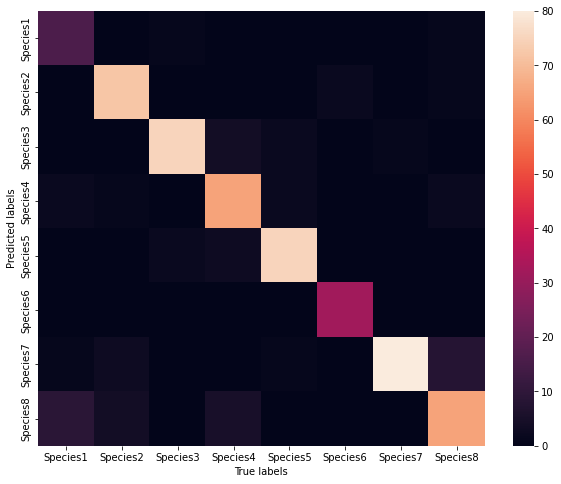

In [ ]:
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)

# Evaluate on test
predictions = model.predict(test_gen, steps=test_steps_per_epoch)

# Get most likely classes
predicted_classes = np.argmax(predictions, axis=-1)

# Get true classes
true_classes = test_gen.classes
class_labels = test_gen.class_indices.keys()

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Compute the classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()